In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import sqlite3
import re
import requests
import pandas as pd
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from numpy.testing import assert_equal
from pywaffle import Waffle

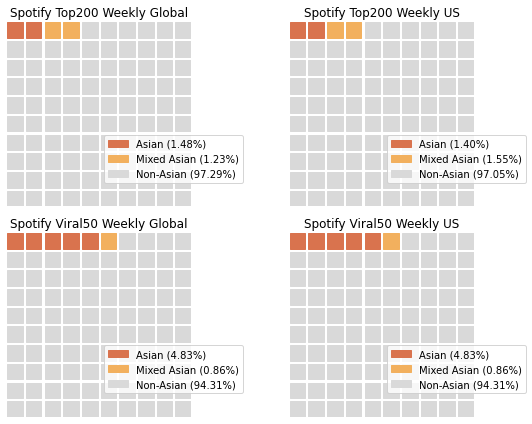

In [3]:
def sql_spotify_chart(chartinfo):
    conn = sqlite3.connect('./pre_processed_data/lab2.db')
    my_sql = f"""
        SELECT lineage,
        COUNT(artist2)
        FROM spotify
        left join wiki_artists
        on name = artist2 
        WHERE chartname = {chartinfo[0]} and 
        chartfreq = {chartinfo[1]} and 
        region = {chartinfo[2]} and
        date > '2016-12-29' and
        date < '2021-08-01'
        GROUP BY lineage
    """
    sptfy_dailyglobal_artist_df = (pd.read_sql(my_sql, conn)
                                   .replace([None], np.nan))
    conn.close()
    sptfy_dailyglobal_artist_df['lineage'].fillna('Non-Asian', inplace=True)
    sptfy_dailyglobal_artist_df.set_index('lineage', inplace=True)
    df_dict = sptfy_dailyglobal_artist_df.to_dict()
    df_dict = df_dict['COUNT(artist2)']
    total = sum(df_dict.values())
    answer = {k: (v/total)*100 for k,v in sorted(df_dict.items())}
    answer2 = [i for i in answer.values()]
    return answer2

spotify_top200_weekly_global = ('\'top200\'', '\'weekly\'', '\'global\'')
spotify_top200_weekly_us = ('\'top200\'', '\'weekly\'', '\'us\'')
spotify_viral50_weekly_global = ('\'viral50\'', '\'weekly\'', '\'global\'')
spotify_viral50_weekly_us = ('\'viral50\'', '\'weekly\'', '\'us\'')

spotify_data = (spotify_top200_weekly_global, spotify_top200_weekly_us, 
                spotify_viral50_weekly_global, spotify_viral50_weekly_us)

spotify_titles = ['Spotify Top200 Weekly Global', 
                  'Spotify Top200 Weekly US', 
                  'Spotify Viral50 Weekly Global', 
                  'Spotify Viral50 Weekly US']

top200_wk_global = sql_spotify_chart(spotify_top200_weekly_global)
top200_wk_us = sql_spotify_chart(spotify_top200_weekly_us)
viral50_wk_global = sql_spotify_chart(spotify_viral50_weekly_global)
viral50_wk_us = sql_spotify_chart(spotify_viral50_weekly_global)

data = pd.DataFrame(
{
    'lineage': ['Asian', 'Mixed Asian', 'Non-Asian'],
    spotify_titles[0]: top200_wk_global,
    spotify_titles[1]: top200_wk_us,
    spotify_titles[2]: viral50_wk_global,
    spotify_titles[3]: viral50_wk_us
},   
).set_index('lineage')

labels = [i for i in data.index]

fig = plt.figure(
FigureClass=Waffle,
plots={
    
221: {
'values': data[spotify_titles[0]],
'labels': labels,
'title': {'label': spotify_titles[0],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[spotify_titles[0]].items()]}
},
    
222: {
'values': data[spotify_titles[1]],
'labels': labels,
'title': {'label': spotify_titles[1],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[spotify_titles[1]].items()]}
},
    
223: {
'values': data[spotify_titles[2]],
'labels': labels,
'title': {'label': spotify_titles[2],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[spotify_titles[2]].items()]}
},
        
224: {
'values': data[spotify_titles[3]],
'labels': labels,
'title': {'label': spotify_titles[3],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[spotify_titles[3]].items()]}
}
       
},

starting_location='NW',
vertical=True,
rows=10,
columns=10,
rounding_rule='ceil',
colors=('#D9734E', '#F2B05E', '#D9D9D9'),
figsize=(8, 6),
)

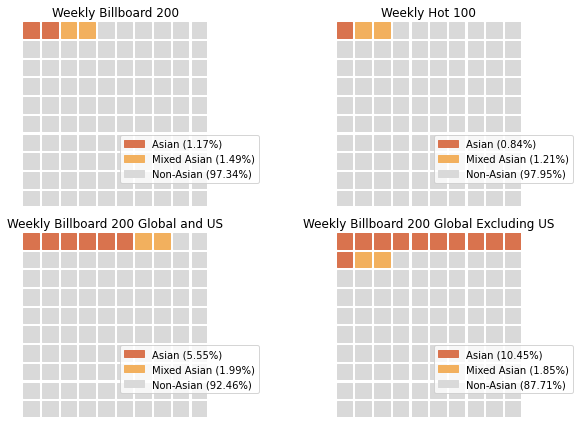

In [4]:
def sql_billboard_charts(chartinfo):
    conn = sqlite3.connect('./pre_processed_data/lab2.db')
    my_sql = f"""
    SELECT *
    FROM billboard
    LEFT JOIN wiki_artists
    ON name = artist
    WHERE chartname = {chartinfo} and
    date > '2016-12-29' and
    date < '2021-08-01'
    """
    bb_artist_df = pd.read_sql(my_sql, conn).replace([None], np.nan)
    conn.close()

    bb_artist_df['country'].fillna('Non-Asian', inplace=True)
    bb_artist_df['lineage'].fillna('Non-Asian', inplace=True)
    bb_df = pd.DataFrame(bb_artist_df.groupby
                         ('lineage')['artist'].agg('count'))
    bb_df = bb_df.to_dict()
    bb_df = bb_df['artist']
    total = sum(bb_df.values())
    answer = {k: (v/total)*100 for k,v in sorted(bb_df.items())}
    answer2 = [i for i in answer.values()]
    return answer2

billboard_data = ['\'weekly_billboard_200\'', 
                  '\'weekly_hot_100\'', 
                  '\'weekly_billboard_global_200\'', 
                  '\'weekly_billboard_global_exclUS_200\'']
                    
billboard_titles = ['Weekly Billboard 200', 
                    'Weekly Hot 100', 
                    'Weekly Billboard 200 Global and US', 
                    'Weekly Billboard 200 Global Excluding US']

wk_200 = sql_billboard_charts(billboard_data[0])
wk_hot100 = sql_billboard_charts(billboard_data[1])
wk_bb200_globalus = sql_billboard_charts(billboard_data[2])
wk_bb200_globalexus = sql_billboard_charts(billboard_data[3])

data = pd.DataFrame(
{
    'lineage': ['Asian', 'Mixed Asian', 'Non-Asian'],
    billboard_titles[0]: wk_200,
    billboard_titles[1]: wk_hot100,
    billboard_titles[2]: wk_bb200_globalus,
    billboard_titles[3]: wk_bb200_globalexus
},   
).set_index('lineage')

labels = [i for i in data.index]

fig = plt.figure(
FigureClass=Waffle,
plots={
    
221: {
'values': data[billboard_titles[0]],
'labels': labels,
'title': {'label': billboard_titles[0],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[billboard_titles[0]].items()]}
},
    
222: {
'values': data[billboard_titles[1]],
'labels': labels,
'title': {'label': billboard_titles[1],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[billboard_titles[1]].items()]}
},
    
223: {
'values': data[billboard_titles[2]],
'labels': labels,
'title': {'label': billboard_titles[2],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[billboard_titles[2]].items()]}
},
        
224: {
'values': data[billboard_titles[3]],
'labels': labels,
'title': {'label': billboard_titles[3],'loc': 'center'},
'legend': {'loc': 'lower left', 'bbox_to_anchor': (.5, .1), 
           'labels': [f"{k} ({v:.2f}%)" for 
                      k, v in data[billboard_titles[3]].items()]}
}
       
},

starting_location='NW',
vertical=True,
rows=10,
columns=10,
rounding_rule='ceil',
colors=('#D9734E', '#F2B05E', '#D9D9D9'),
figsize=(9, 6),
)